In [ ]:
!pip install pymystem3==0.1.10
#а то гугл коллаб отказывается лемматизировать 

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.auto import tqdm, trange
from pymystem3 import Mystem
import nltk
from nltk.stem import *
from nltk.corpus import stopwords
from string import punctuation
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer 
stemmer = SnowballStemmer("russian") 
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
#монтируем с гугл диска чтоб не закачивать постоянно
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/20170301.csv')



---


### **1. изучение датасета новостей**


---



Далее познакомимся с данными, со структурой датасета, посмотрим пропуски

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576383 entries, 0 to 576382
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   u_id         576383 non-null  int64 
 1   provider     576383 non-null  object
 2   date_time    576383 non-null  object
 3   title        576383 non-null  object
 4   description  542805 non-null  object
 5   link         576292 non-null  object
 6   pubdate      576383 non-null  object
 7   numfield     576383 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 35.2+ MB


в поле описания имеется очень много пропусков, здесь логично встсавить туда хотя бы краткое описание title

In [ ]:
df.head()

,u_id,provider,date_time,title,description,link,pubdate,numfield
0,103451,washingtonpostcom_world[eng],2017-01-17 20:15:49,"""$10,000 stuffed in a diplomat-s car."" Moscow ...",Russia-s foreign minister said that United Sta...,https://www.washingtonpost.com/news/worldviews...,17.01.2017 20:15,3
1,211367,vsesmiru_business,2017-02-02 06:00:33,"""100 друзей"" Гродненского мясокомбината",Дизайнеры агентства Fabula Branding (Минск) пр...,http://www.vsesmi.ru/business/2017/02/02/321648/,02.02.2017 01:03,4
2,13559,mailru_common,2016-11-28 13:30:23,"""12-я партия - игра жизни не только Карякина, ...",<p>Победитель шахматной олимпиады 1998 гроссме...,https://sport.mail.ru/news/chess/27940207/,28.11.2016 13:22,4
3,17165,mailru_common,2016-11-28 21:15:25,"""37 мне только по паспорту"". Почему Лебедев не...","<p>Боксёры Денис Лебедев и Мурат Гассиев, встр...",https://sport.mail.ru/news/boxing/27946630/,28.11.2016 21:09,4
4,147533,mailru_polit,2017-01-24 10:15:32,"""5 канал"": Украина подала в ЕСПЧ пять исков пр...",<p>Речь идет о событиях в Крыму и Донбассе и н...,https://news.mail.ru/politics/28526323/,24.01.2017 10:04,4


In [ ]:
df['description']=df['description'].fillna(df['title'])


In [ ]:
df=df[df['link'].str.contains("business") | df['link'].str.contains("finance") | df['link'].str.contains("economy")]


In [ ]:
def detect_ru(row):
  alphabet = {"а","б","в","г","д","е","ё","ж","з","и","й","к","л","м","н","о",
              "п","р","с","т","у","ф","х","ц","ч","ш","щ","ъ","ы","ь","э","ю","я"}

  text = row['description']
  return bool(alphabet.intersection(set(text.lower())))


In [ ]:
df['Languagereveiw'] = df.apply(detect_ru, axis=1)

In [ ]:
df=df[df['Languagereveiw']==True ].reset_index(drop=True)
df.head()

,u_id,provider,date_time,title,description,link,pubdate,numfield,Languagereveiw
0,211367,vsesmiru_business,2017-02-02 06:00:33,"""100 друзей"" Гродненского мясокомбината",Дизайнеры агентства Fabula Branding (Минск) пр...,http://www.vsesmi.ru/business/2017/02/02/321648/,02.02.2017 01:03,4,True
1,353361,vsesmiru_business,2017-02-24 09:00:34,"""ArcelorMittal Кривой Рог"" инициировал антидем...","В течение 30 дней, с даты публикации сообщения...",http://www.vsesmi.ru/business/2017/02/24/385699/,24.02.2017 08:31,4,True
2,65369,newrucom_common,2016-12-05 20:30:06,"""Абсолютно никчемный аргумент"": Путин прокомме...",Глава государства назвал совершенно не имеющей...,http://www.newsru.com/finance/05dec2016/gazpro...,05.12.2016 20:26,4,True
3,58879,vsesmiru_business,2017-01-11 07:45:35,"""Аврора"" со следующей недели открывает новый р...","Интерфакс-Россия, Новость:\nАвиакомпания ""Авро...",http://www.vsesmi.ru/business/2017/01/11/256028/,11.01.2017 07:26,4,True
4,243101,vestifinance_common,2017-02-07 11:15:54,"""АвтоВАЗ"" наращивает продажи. Главное",Отечественный концерн по производству автомоби...,http://www.vestifinance.ru/videos/32121,07.02.2017 11:11,4,True


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37243 entries, 0 to 37242
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   u_id            37243 non-null  int64 
 1   provider        37243 non-null  object
 2   date_time       37243 non-null  object
 3   title           37243 non-null  object
 4   description     37243 non-null  object
 5   link            37243 non-null  object
 6   pubdate         37243 non-null  object
 7   numfield        37243 non-null  int64 
 8   Languagereveiw  37243 non-null  bool  
dtypes: bool(1), int64(2), object(6)
memory usage: 2.3+ MB


In [ ]:
df.duplicated().sum()

0

In [ ]:
#df=df[:2150]

In [ ]:
dout=df['description']

In [ ]:
dout.duplicated().sum()

NameError: ignored

In [ ]:
dout = dout.drop_duplicates()

In [ ]:
dout.describe()

In [ ]:
dout.to_csv("descr.csv", index=False)

In [ ]:
dout.head(15)

In [ ]:
from google.colab import files
files.download("descr.csv")

**!!!СЕЙЧАС ТУТ и  РАЗМЕЧАЮ вручную 2000 примеров, беру только русские новости, иначе нереал**



---


### **2. Подготовка обучающего датасета**

---



In [ ]:
df_train=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/descr_labeled.csv',sep='I',error_bad_lines=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df_train.head(20)

,description,label
0,Дизайнеры агентства Fabula Branding (Минск) пр...,1
1,"В течение 30 дней, с даты публикации сообщения...",2
2,Глава государства назвал совершенно не имеющей...,2
3,"Интерфакс-Россия, Новость: Авиакомпания ""Аврор...",3
4,Отечественный концерн по производству автомоби...,4
5,"""АвтоВАЗ"" начал продажи автомобилей Lada Vesta...",3
6,"Совет директоров ""АвтоВАЗа"" принял стратегичес...",4
7,"""АвтоВАЗ"" завершил размещение дополнительных а...",3
8,"""АвтоВАЗ"" в январе увеличил продажи на 4,6% в ...",4
9,"""АвтоВАЗ"" сократит 740 человек (2% сотрудников...",5


In [ ]:
df_train.tail(10)

,description,label
2059,"Шведский концерн IKEA, которому принадлежит кр...",3
2060,Шведская компания IKEA выплатит $50 млн в каче...,2
2061,"Компания IRI Investments Lietuva, контролируем...",3
2062,Краснинский суд Смоленской области арестовал с...,2
2063,Шведская компания IKEA не согласна с решением ...,2
2064,Шведская IKEA не будет строить торговый центр ...,3
2065,Шведская IKEA планирует выставить права на дол...,3
2066,Шведская компания IKEA намерена трудоустроить ...,3
2067,Шведский ритейлер IKEA направил обращение упол...,2
2068,Каждый пятый товар сети подешевеет на 15–20%,5


разметили вручную новости в программе CSVpad 


метки ставятся следующим образом  

1 - реклама, позитивное ожидание чего-либо 

 2 - судебные дела, иски, претензии 

3 - информационное сообщение нейтральное по смыслу 

4 - рост продаж, производства, поставок - позитив по сути 

5 - уменьшение чего - либо, продаж, поставок и т.д.  - негатив короче

In [ ]:
df_train['label'].value_counts()

3    1125
1     464
2     213
4     155
5     112
Name: label, dtype: int64

ок, теперь есть столбец текста новости и столбец метки новости! можно двигаться дальше



---


### 3. Очищение текста новости


---



удаляем стоп слова, обрабатываем текст

In [ ]:
import string
def remove_punctuation(text):
    return "".join([ch if ch not in string.punctuation else ' ' for ch in text])

def remove_numbers(text):
    return ''.join([i if not i.isdigit() else ' ' for i in text])

import re
def remove_multiple_spaces(text):
	return re.sub(r'\s+', ' ', text, flags=re.I)


mystem = Mystem() 

russian_stopwords = stopwords.words("russian")
russian_stopwords.extend(['…', '«', '»', '...'])
def lemmatize_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords and token != " "]
    text = " ".join(tokens)
    return text

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz


In [ ]:
#df_train=df.reset_index(drop = True)

In [ ]:
preproccessing = lambda text: (remove_multiple_spaces(remove_numbers(remove_punctuation(text))))
df_train['preproccessed'] = list(map(preproccessing, df_train['description']))

очистили текст от пунктуации, от пробелов, от цифр, и переведем в нижний регистр

In [ ]:
prep_text = [remove_multiple_spaces(remove_numbers(remove_punctuation(text.lower()))) for text in tqdm(df_train['description'])]

  0%|          | 0/2069 [00:00<?, ?it/s]

In [ ]:
len(prep_text)
prep_text[0]

'дизайнеры агентства fabula branding минск провели комплексную разработку торговой марки колбасных изделий « друзей» нейминг логотип дизайн упаковки для оао «гродненский мясокомбинат» продукт – колбасные изделия среднего ценового сегмента сырокопченые сыровяленые вареные колбасы сосиски и сардельки регионы продаж – беларусь и россия ситуации потребления дружеские и семейные застолья пикник гости быстрый перекус целевая аудитория – мужчины и женщины лет решением стал теплый и яркий желтый цвет который хорошо отстраивает продукт на полке служит цветовым идентификатором торговой марки и вызывает приятные ассоциации с пикником дружескими посиделками на даче дружелюбную и приветливую стилистику дизайна поддерживает цифра « » образованная колбасками маркер категории а также рукописный шрифт логотипа '

In [ ]:
df_train['text_prep'] = prep_text

In [ ]:
df_train.head()

,description,label,preproccessed,text_prep
0,Дизайнеры агентства Fabula Branding (Минск) пр...,1,Дизайнеры агентства Fabula Branding Минск пров...,дизайнеры агентства fabula branding минск пров...
1,"В течение 30 дней, с даты публикации сообщения...",2,В течение дней с даты публикации сообщения в У...,в течение дней с даты публикации сообщения в у...
2,Глава государства назвал совершенно не имеющей...,2,Глава государства назвал совершенно не имеющей...,глава государства назвал совершенно не имеющей...
3,"Интерфакс-Россия, Новость: Авиакомпания ""Аврор...",3,Интерфакс Россия Новость Авиакомпания Аврора с...,интерфакс россия новость авиакомпания аврора с...
4,Отечественный концерн по производству автомоби...,4,Отечественный концерн по производству автомоби...,отечественный концерн по производству автомоби...




---


### 4. Стэмминг


---



In [ ]:
russian_stopwords = stopwords.words("russian")
russian_stopwords.extend(['…', '«', '»', '...', 'т.д.', 'т', 'д'])

In [ ]:
text = df_train['text_prep'][1]
word_tokenize(text) 

In [ ]:
stemmed_texts_list = []
for text in tqdm(df_train['text_prep']):
    tokens = word_tokenize(text)    
    stemmed_tokens = [stemmer.stem(token) for token in tokens if token not in russian_stopwords]
    text = " ".join(stemmed_tokens)
    stemmed_texts_list.append(text)

df_train['text_stem'] = stemmed_texts_list

  0%|          | 0/2069 [00:00<?, ?it/s]

In [ ]:
def remove_stop_words(text):
    tokens = word_tokenize(text) 
    tokens = [token for token in tokens if token not in russian_stopwords and token != ' ']
    return " ".join(tokens)

In [ ]:
sw_texts_list = []
for text in tqdm(df_train['text_prep']):
    tokens = word_tokenize(text)    
    tokens = [token for token in tokens if token not in russian_stopwords and token != ' ']
    text = " ".join(tokens)
    sw_texts_list.append(text)

df_train['text_sw'] = sw_texts_list

In [ ]:
df_train.head()

,description,label,preproccessed,text_prep,text_stem,text_sw,text_lemm
0,Дизайнеры агентства Fabula Branding (Минск) пр...,1,Дизайнеры агентства Fabula Branding Минск пров...,дизайнеры агентства fabula branding минск пров...,дизайнер агентств fabul branding минск провел ...,дизайнеры агентства fabula branding минск пров...,дизайнер агентство fabula branding минск прово...
1,"В течение 30 дней, с даты публикации сообщения...",2,В течение дней с даты публикации сообщения в У...,в течение дней с даты публикации сообщения в у...,течен дне дат публикац сообщен урядов курьер м...,течение дней даты публикации сообщения урядово...,течение день дата публикация сообщение урядово...
2,Глава государства назвал совершенно не имеющей...,2,Глава государства назвал совершенно не имеющей...,глава государства назвал совершенно не имеющей...,глав государств назва совершен имеющ соб основ...,глава государства назвал совершенно имеющей со...,глава государство называть совершенно иметь ос...
3,"Интерфакс-Россия, Новость: Авиакомпания ""Аврор...",3,Интерфакс Россия Новость Авиакомпания Аврора с...,интерфакс россия новость авиакомпания аврора с...,интерфакс росс новост авиакомпан аврор январ г...,интерфакс россия новость авиакомпания аврора я...,интерфакс россия новость авиакомпания аврора я...
4,Отечественный концерн по производству автомоби...,4,Отечественный концерн по производству автомоби...,отечественный концерн по производству автомоби...,отечествен концерн производств автомобил отчит...,отечественный концерн производству автомобилей...,отечественный концерн производство автомобиль ...




---


### 5. Лемматизация


---



In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2069 entries, 0 to 2068
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   description    2069 non-null   object
 1   label          2069 non-null   int64 
 2   preproccessed  2069 non-null   object
 3   text_prep      2069 non-null   object
 4   text_stem      2069 non-null   object
 5   text_sw        2069 non-null   object
dtypes: int64(1), object(5)
memory usage: 97.1+ KB


In [ ]:
lemm_texts_list = []
for text in tqdm(df_train['text_sw']):
    #print(text)
    try:
        text_lem = mystem.lemmatize(text)
        tokens = [token for token in text_lem if token != ' ' and token not in russian_stopwords]
        text = " ".join(tokens)
        lemm_texts_list.append(text)
    except Exception as e:
        print(e)
    
df_train['text_lemm'] = lemm_texts_list

  0%|          | 0/2069 [00:00<?, ?it/s]

In [ ]:
df_train.tail(20)

,description,label,preproccessed,text_prep,text_stem,text_sw,text_lemm
2049,От Ассоциации предприятий информационных техно...,3,От Ассоциации предприятий информационных техно...,от ассоциации предприятий информационных техно...,ассоциац предприят информацион технолог украин...,ассоциации предприятий информационных технолог...,ассоциация предприятие информационный технолог...
2050,IBU временно отстранил от соревнований российс...,2,IBU временно отстранил от соревнований российс...,ibu временно отстранил от соревнований российс...,ib времен отстран соревнован российск биатлони...,ibu временно отстранил соревнований российскую...,ibu временно отстранять соревнование российски...
2051,АйСиБиСи Банк (100% &amp;quot;дочка&amp;quot; ...,3,АйСиБиСи Банк amp quot дочка amp quot крупнейш...,айсибиси банк amp quot дочка amp quot крупнейш...,айсибис банк amp quot дочк amp quot крупн банк...,айсибиси банк amp quot дочка amp quot крупнейш...,айсибиси банк amp quot дочка amp quot крупный ...
2052,В феврале 2017 года состоится первая встреча с...,3,В феврале года состоится первая встреча с поте...,в феврале года состоится первая встреча с поте...,феврал год состо перв встреч потенциальн инвес...,феврале года состоится первая встреча потенциа...,февраль год состояться первый встреча потенциа...
2053,Исламская корпорация по развитию частного сект...,3,Исламская корпорация по развитию частного сект...,исламская корпорация по развитию частного сект...,исламск корпорац развит частн сектор,исламская корпорация развитию частного сектора,исламский корпорация развитие частный сектор \n
2054,Россия и Объединенные Арабские Эмираты договор...,1,Россия и Объединенные Арабские Эмираты договор...,россия и объединенные арабские эмираты договор...,росс объединен арабск эмират договор развива с...,россия объединенные арабские эмираты договорил...,россия объединять арабский эмират договаривать...
2055,Каир продолжает рассматривать российское предл...,3,Каир продолжает рассматривать российское предл...,каир продолжает рассматривать российское предл...,каир продолжа рассматрива российск предложен к...,каир продолжает рассматривать российское предл...,каир продолжать рассматривать российский предл...
2056,"IKEA Group, являющаяся оператором большинства ...",3,IKEA Group являющаяся оператором большинства м...,ikea group являющаяся оператором большинства м...,ike group явля оператор большинств магазин ike...,ikea group являющаяся оператором большинства м...,ikea group являться оператор большинство магаз...
2057,Каждый сотрудник шведской корпорации IKEA в Ве...,1,Каждый сотрудник шведской корпорации IKEA в Ве...,каждый сотрудник шведской корпорации ikea в ве...,кажд сотрудник шведск корпорац ike великобрита...,каждый сотрудник шведской корпорации ikea вели...,каждый сотрудник шведский корпорация ikea вели...
2058,Каждый сотрудник шведской корпорации IKEA в Ве...,1,Каждый сотрудник шведской корпорации IKEA в Ве...,каждый сотрудник шведской корпорации ikea в ве...,кажд сотрудник шведск корпорац ike великобрита...,каждый сотрудник шведской корпорации ikea вели...,каждый сотрудник шведский корпорация ikea вели...


In [ ]:
df_train.to_csv('df_train_prep.csv', index=False)

In [ ]:
from google.colab import files
files.download("df_train_prep.csv")

FileNotFoundError: ignored

In [ ]:
X = df_train['text_sw']
y = df_train['label']

разобьем обучающий датасет на тренировку и тестирование

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [ ]:
X[0]

'дизайнеры агентства fabula branding минск провели комплексную разработку торговой марки колбасных изделий друзей нейминг логотип дизайн упаковки оао гродненский мясокомбинат продукт – колбасные изделия среднего ценового сегмента сырокопченые сыровяленые вареные колбасы сосиски сардельки регионы продаж – беларусь россия ситуации потребления дружеские семейные застолья пикник гости быстрый перекус целевая аудитория – мужчины женщины лет решением стал теплый яркий желтый цвет который отстраивает продукт полке служит цветовым идентификатором торговой марки вызывает приятные ассоциации пикником дружескими посиделками даче дружелюбную приветливую стилистику дизайна поддерживает цифра образованная колбасками маркер категории также рукописный шрифт логотипа'

In [ ]:
y[0]

1


---


### 6. Байесовский классификатор


---


In [ ]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

In [ ]:
%%time
nb.fit(X_train, y_train)

CPU times: user 87.8 ms, sys: 6.12 ms, total: 93.9 ms
Wall time: 114 ms


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [ ]:
%%time
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

CPU times: user 24.4 ms, sys: 0 ns, total: 24.4 ms
Wall time: 25.4 ms


In [ ]:
y_pred[0]

3

In [ ]:
my_tags = df_train['label'].unique().astype('str')
my_tags

array(['1', '2', '3', '4', '5'], dtype='<U21')

In [ ]:

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=my_tags))

accuracy 0.5684380032206119
              precision    recall  f1-score   support

           1       0.88      0.10      0.19       143
           2       1.00      0.03      0.06        68
           3       0.56      1.00      0.72       335
           4       0.33      0.03      0.05        38
           5       0.00      0.00      0.00        37

    accuracy                           0.57       621
   macro avg       0.55      0.23      0.20       621
weighted avg       0.63      0.57      0.44       621



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




---


### Linear Support Vector Machine


---



In [ ]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('sgd', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])

In [ ]:
%%time
sgd.fit(X_train, y_train)

CPU times: user 99.7 ms, sys: 14.8 ms, total: 114 ms
Wall time: 108 ms


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('sgd',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

In [ ]:
%%time
y_pred = sgd.predict(X_test)

CPU times: user 27.2 ms, sys: 0 ns, total: 27.2 ms
Wall time: 30.3 ms


In [ ]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.6280193236714976
              precision    recall  f1-score   support

           1       0.59      0.22      0.32       143
           2       0.84      0.38      0.53        68
           3       0.63      0.96      0.76       335
           4       0.38      0.24      0.29        38
           5       0.60      0.08      0.14        37

    accuracy                           0.63       621
   macro avg       0.61      0.38      0.41       621
weighted avg       0.63      0.63      0.57       621



### Случайный лес

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('rf', RandomForestClassifier()),
               ])

In [ ]:
%%time
rf_model.fit(X_train, y_train)

CPU times: user 1.12 s, sys: 4.03 ms, total: 1.12 s
Wall time: 1.12 s


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('rf', RandomForestClassifier())])

In [ ]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.6280193236714976
              precision    recall  f1-score   support

           1       0.59      0.22      0.32       143
           2       0.84      0.38      0.53        68
           3       0.63      0.96      0.76       335
           4       0.38      0.24      0.29        38
           5       0.60      0.08      0.14        37

    accuracy                           0.63       621
   macro avg       0.61      0.38      0.41       621
weighted avg       0.63      0.63      0.57       621



### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('logreg', LogisticRegression(n_jobs=1, C=1e5)),
               ])

In [ ]:
%%time
logreg.fit(X_train, y_train)

CPU times: user 1.92 s, sys: 2.26 s, total: 4.18 s
Wall time: 2.39 s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('logreg', LogisticRegression(C=100000.0, n_jobs=1))])

In [ ]:
%%time
y_pred = logreg.predict(X_test)

CPU times: user 51.2 ms, sys: 75.1 ms, total: 126 ms
Wall time: 70.6 ms


In [ ]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.642512077294686
              precision    recall  f1-score   support

           1       0.55      0.36      0.43       143
           2       0.79      0.46      0.58        68
           3       0.67      0.87      0.76       335
           4       0.42      0.50      0.46        38
           5       0.67      0.16      0.26        37

    accuracy                           0.64       621
   macro avg       0.62      0.47      0.50       621
weighted avg       0.64      0.64      0.62       621



In [ ]:
X_train[0]

'дизайнеры агентства fabula branding минск провели комплексную разработку торговой марки колбасных изделий друзей нейминг логотип дизайн упаковки оао гродненский мясокомбинат продукт – колбасные изделия среднего ценового сегмента сырокопченые сыровяленые вареные колбасы сосиски сардельки регионы продаж – беларусь россия ситуации потребления дружеские семейные застолья пикник гости быстрый перекус целевая аудитория – мужчины женщины лет решением стал теплый яркий желтый цвет который отстраивает продукт полке служит цветовым идентификатором торговой марки вызывает приятные ассоциации пикником дружескими посиделками даче дружелюбную приветливую стилистику дизайна поддерживает цифра образованная колбасками маркер категории также рукописный шрифт логотипа'

In [ ]:
y_pred[0]

3

In [ ]:
travel_text = '''отечественный концерн производству автомобилей отчитался росте продаж январе показатель увеличился тысяч единиц прогнозам компании lada vesta выйти третье место объему продаж россии'''

In [ ]:
grow_up = remove_multiple_spaces(remove_numbers(remove_punctuation(travel_text.lower())))
grow_up = remove_stop_words(travel_text)

In [ ]:
pred = logreg.predict([grow_up])
pred

array([4])

было верно предсказана категория 4 - то есть новости об увеличении экономических показателей

In [ ]:
sud_text='течение дней даты публикации сообщения урядовом курьере министерство проводить регистрацию заинтересованных расследовании лиц рассматривает требования относительно проведения слушаний течение дней мэрт рассматривает письменно изложенные комментарии информацию относительно возбуждения расследования'

In [ ]:
sud = remove_multiple_spaces(remove_numbers(remove_punctuation(sud_text.lower())))
sud = remove_stop_words(travel_text)

In [ ]:
pred = logreg.predict([sud])
pred

array([4])

### Кластеризация

In [ ]:
texts = df_train['description']
type(texts)

pandas.core.series.Series

In [ ]:
def token_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[а-яА-Я]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [ ]:
stopwords = nltk.corpus.stopwords.words('russian')
#можно расширить список стоп-слов
stopwords.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', 'к', 'на'])

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

n_featur=200000
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000,
                                 min_df=0.01, stop_words=stopwords,
                                 use_idf=True, tokenizer=token_and_stem, ngram_range=(1,3))

In [ ]:
%%time
tfidf_matrix = tfidf_vectorizer.fit_transform(texts)


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['бол', 'больш', 'будт', 'быт', 'вед', 'впроч', 'всег', 'всегд', 'даж', 'друг', 'е', 'ег', 'ем', 'есл', 'ест', 'ещ', 'зач', 'зде', 'ил', 'иногд', 'когд', 'конечн', 'куд', 'лучш', 'межд', 'мен', 'мног', 'мо', 'можн', 'нег', 'нельз', 'нибуд', 'никогд', 'нич', 'опя', 'посл', 'пот', 'почт', 'разв', 'сво', 'себ', 'совс', 'теб', 'тепер', 'тог', 'тогд', 'тож', 'тольк', 'хорош', 'хот', 'чег', 'чут', 'эт'] not in stop_words.
  % sorted(inconsistent)


CPU times: user 5.07 s, sys: 25.7 ms, total: 5.09 s
Wall time: 5.1 s


In [ ]:
type(tfidf_matrix)
tfidf_matrix

<2069x462 sparse matrix of type '<class 'numpy.float64'>'
	with 22658 stored elements in Compressed Sparse Row format>

In [ ]:
num_clusters = 5

# Метод к-средних - KMeans
from sklearn.cluster import KMeans
km = KMeans(n_clusters=num_clusters)

In [ ]:
%%time
km.fit(tfidf_matrix)

CPU times: user 573 ms, sys: 15.8 ms, total: 589 ms
Wall time: 322 ms


KMeans(n_clusters=5)

In [ ]:
%%time
idx = km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

CPU times: user 628 ms, sys: 9.28 ms, total: 638 ms
Wall time: 338 ms


In [ ]:
len(km.labels_)
clusters[:10]

[1, 1, 1, 1, 1, 1, 0, 1, 0, 1]

In [ ]:
clusterkm = km.labels_.tolist()
frame = pd.DataFrame(texts)

#k-means
out = { 'text': texts, 'cluster': clusterkm, 'topic': df_train['label'] }
frame1 = pd.DataFrame(out, columns = ['text', 'cluster', 'topic'])

In [ ]:
frame1.head(10)

,text,cluster,topic
0,Дизайнеры агентства Fabula Branding (Минск) пр...,1,1
1,"В течение 30 дней, с даты публикации сообщения...",1,2
2,Глава государства назвал совершенно не имеющей...,1,2
3,"Интерфакс-Россия, Новость: Авиакомпания ""Аврор...",1,3
4,Отечественный концерн по производству автомоби...,1,4
5,"""АвтоВАЗ"" начал продажи автомобилей Lada Vesta...",1,3
6,"Совет директоров ""АвтоВАЗа"" принял стратегичес...",0,4
7,"""АвтоВАЗ"" завершил размещение дополнительных а...",1,3
8,"""АвтоВАЗ"" в январе увеличил продажи на 4,6% в ...",0,4
9,"""АвтоВАЗ"" сократит 740 человек (2% сотрудников...",1,5


In [ ]:
frame1.tail(10)

,text,cluster,topic
2059,"Шведский концерн IKEA, которому принадлежит кр...",1,3
2060,Шведская компания IKEA выплатит $50 млн в каче...,0,2
2061,"Компания IRI Investments Lietuva, контролируем...",0,3
2062,Краснинский суд Смоленской области арестовал с...,3,2
2063,Шведская компания IKEA не согласна с решением ...,3,2
2064,Шведская IKEA не будет строить торговый центр ...,1,3
2065,Шведская IKEA планирует выставить права на дол...,1,3
2066,Шведская компания IKEA намерена трудоустроить ...,0,3
2067,Шведский ритейлер IKEA направил обращение упол...,1,2
2068,Каждый пятый товар сети подешевеет на 15–20%,1,5


In [ ]:
frame1.describe()

,cluster,topic
count,2069.000000,2069.000000
mean,1.085549,2.631706
std,0.942203,1.075344
min,0.000000,1.000000
25%,1.000000,2.000000
50%,1.000000,3.000000
75%,1.000000,3.000000
max,4.000000,5.000000


## Биграммы, триграммы и прочее

In [ ]:
from __future__ import unicode_literals
import nltk
from nltk import word_tokenize
from nltk.util import ngrams
from collections import Counter

In [ ]:
def main_words1(row):
      return nltk.word_tokenize(row['description'])# токинезация текста i-го документа 

In [ ]:
words1=df_train.apply(main_words1,axis=1)
words1

0       [Дизайнеры, агентства, Fabula, Branding, (, Ми...
1       [В, течение, 30, дней, ,, с, даты, публикации,...
2       [Глава, государства, назвал, совершенно, не, и...
3       [Интерфакс-Россия, ,, Новость, :, Авиакомпания...
4       [Отечественный, концерн, по, производству, авт...
                              ...                        
2145    [Шведская, IKEA, не, будет, строить, торговый,...
2146    [Шведская, IKEA, планирует, выставить, права, ...
2147    [Шведская, компания, IKEA, намерена, трудоустр...
2148    [Шведский, ритейлер, IKEA, направил, обращение...
2149    [Каждый, пятый, товар, сети, подешевеет, на, 1...
Length: 2150, dtype: object

In [ ]:
ww=[]
for i in range(len(words1)):
  if type(words1[i])==list:
     ww=ww+words1[i]
word = list(filter(lambda x: x  != 'quot', ww))
word_ws=[w.lower()  for w in   word if w.isalpha() ]#исключение слов и символов      
token=[w for w in word_ws if w not in russian_stopwords ]#нижний регистр 

bigrams = ngrams(token,2)
trigrams = ngrams(token,3)
fourgrams = ngrams(token,4)
fivegrams = ngrams(token,5)

In [ ]:
Counter(bigrams).most_common(5)

[(('говорится', 'сообщении'), 65),
 (('млрд', 'рублей'), 63),
 (('уровне', 'баррель'), 62),
 (('deutsche', 'bank'), 53),
 (('млрд', 'руб'), 47)]

In [ ]:
Counter(trigrams).most_common(5)

[(('фьючерсы', 'brent', 'торговались'), 35),
 (('сообщает', 'rns', 'ссылкой'), 25),
 (('бирже', 'ice', 'futures'), 24),
 (('рейтинговое', 'агентство', 'fitch'), 24),
 (('сша', 'дональда', 'трампа'), 23)]

In [ ]:
Counter(fourgrams).most_common(5)

[(('лондонской', 'бирже', 'ice', 'futures'), 23),
 (('президента', 'сша', 'дональда', 'трампа'), 22),
 (('международное', 'рейтинговое', 'агентство', 'fitch'), 21),
 (('фьючерсы', 'brent', 'торговались', 'лондоне'), 20),
 (('brent', 'торговались', 'лондоне', 'уровне'), 20)]

In [ ]:
Counter(fivegrams).most_common(5)

[(('фьючерсы', 'brent', 'торговались', 'лондоне', 'уровне'), 20),
 (('brent', 'торговались', 'лондоне', 'уровне', 'баррель'), 20),
 (('электронных', 'торгах', 'товарной', 'биржи', 'nymex'), 15),
 (('общий', 'объем', 'продажи', 'иностранной', 'валюты'), 14),
 (('объем', 'продажи', 'иностранной', 'валюты', 'долларовом'), 14)]

### BigARTM

In [ ]:
text=df_train['description']
freq=nltk.FreqDist(text)

посмотрим наиболее часто встречающиеся слова, возможно, отсюда уже можно будет ориентироваться на категории новостей

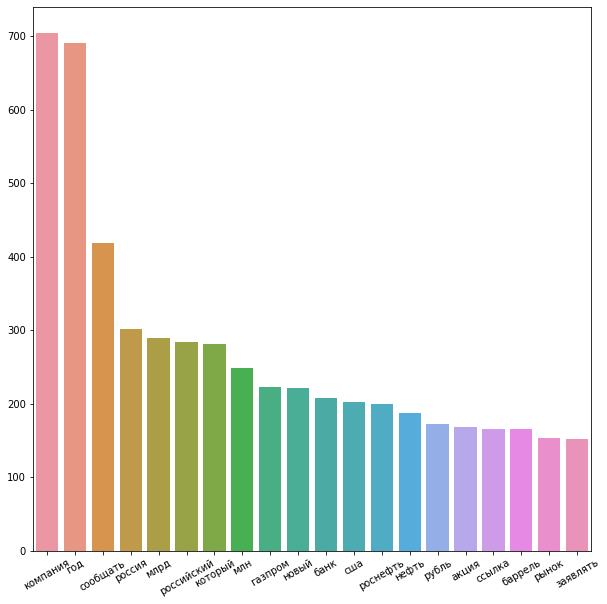

In [ ]:
## Creating FreqDist for whole BoW, keeping the 20 most common tokens
all_fdist = freq.most_common(20)

## Conversion to Pandas series via Python Dictionary for easier plotting
all_fdist = pd.Series(dict(all_fdist))

## Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(10,10))

## Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
all_plot = sns.barplot(x=all_fdist.index, y=all_fdist.values, ax=ax)
plt.xticks(rotation=30);

нет, это все общеупотребительные слова

In [ ]:
text

0       Дизайнеры агентства Fabula Branding (Минск) пр...
1       В течение 30 дней, с даты публикации сообщения...
2       Глава государства назвал совершенно не имеющей...
3       Интерфакс-Россия, Новость:\nАвиакомпания "Авро...
4       Отечественный концерн по производству автомоби...
                              ...                        
2145    Шведская IKEA не будет строить торговый центр ...
2146    Шведская IKEA планирует выставить права на дол...
2147    Шведская компания IKEA намерена трудоустроить ...
2148    Шведский ритейлер IKEA направил обращение упол...
2149         Каждый пятый товар сети подешевеет на 15–20%
Name: description, Length: 2150, dtype: object

In [ ]:
def main_words1(row):
      return nltk.word_tokenize(row['description'])# токинезация текста i-го документа 

In [ ]:
words1=df_train.apply(main_words1,axis=1)

In [ ]:
words1

0       [Дизайнеры, агентства, Fabula, Branding, (, Ми...
1       [В, течение, 30, дней, ,, с, даты, публикации,...
2       [Глава, государства, назвал, совершенно, не, и...
3       [Интерфакс-Россия, ,, Новость, :, Авиакомпания...
4       [Отечественный, концерн, по, производству, авт...
                              ...                        
2145    [Шведская, IKEA, не, будет, строить, торговый,...
2146    [Шведская, IKEA, планирует, выставить, права, ...
2147    [Шведская, компания, IKEA, намерена, трудоустр...
2148    [Шведский, ритейлер, IKEA, направил, обращение...
2149    [Каждый, пятый, товар, сети, подешевеет, на, 1...
Length: 2150, dtype: object

Exception ignored in: <function BatchVectorizer.__del__ at 0x7fc435d63170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/artm/batches_utils.py", line 137, in __del__
    self.__dispose()
  File "/usr/local/lib/python3.7/dist-packages/artm/batches_utils.py", line 130, in __dispose
    shutil.rmtree(self._target_folder)
  File "/usr/lib/python3.7/shutil.py", line 485, in rmtree
    onerror(os.lstat, path, sys.exc_info())
  File "/usr/lib/python3.7/shutil.py", line 483, in rmtree
    orig_st = os.lstat(path)
FileNotFoundError: [Errno 2] No such file or directory: 'urnuuidaf904b00-7ceb-11ec-8661-0242ac1c0002'


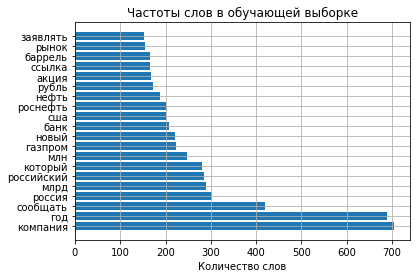

In [ ]:
count=0
ww=[]
for i in range(len(words1)):
  if type(words1[i])==list:
     ww=ww+words1[i]
     count+=1
word = list(filter(lambda x: x  != 'quot', ww))
word_ws=[w.lower()  for w in   word if w.isalpha() ]#исключение слов и символов      
word_w=[w for w in word_ws if w not in russian_stopwords ]#нижний регистр 
lem = mystem.lemmatize ((" ").join(word_w))# лемматизация i -го документа
lem=[w for w in lem if w.isalpha() and len(w)>1] 
freq=nltk.FreqDist(lem)# распределение слов в i -м документе по частоте
z=[]# обновление списка для нового документа
z=[(key+":"+str(val)) for key,val in freq.items() if val>1] # частота упоминания через : от слова 

    #text=text+"|text" +" "+str((" ").join(z))+'\n'# запись в мешок слов с меткой |text     
    #text=text+"|text" +" "+str((" ").join(z).encode('utf-8'))+'\n'# запись в мешок слов с меткой |text          
c=[];d=[]
for key,val in freq.items():#подготовка к сортировке слов по убыванию частоты в i -м документе
        if val>1:
            c.append(val); d.append(key)
a=[];b=[]    
for k in np.arange(0,len(c),1):#сортировка слов по убыванию частоты в i -м документе 
                ind=c.index(max(c));  a.append(c[ind])
                b.append(d[ind]); del c[ind]; del d[ind]

a=a[0:20];b=b[0:20]# TOP-10 для частот a  и слов b в i -м документе    
y_pos = np.arange(1,len(a)+1,1)#построение TOP-10 диаграмм      
performance =a
plt.barh(y_pos, a)
plt.yticks(y_pos, b)
plt.xlabel(u'Количество слов')
plt.title(u'Частоты слов в обучающей выборке', size=12)
plt.grid(True)
plt.show()  




In [ ]:
sw_texts_list = []
for text in tqdm(df_train['text_prep']):
    tokens = word_tokenize(text)    
    tokens = [token for token in tokens if token not in russian_stopwords and token != ' ']
    text = " ".join(tokens)
    sw_texts_list.append(text)

df_train['text_sw'] = sw_texts_list

  0%|          | 0/2069 [00:00<?, ?it/s]

In [ ]:
count

2150

In [ ]:
#здесь теперь word содержит все слова с обучающей выборки
#далее это пригодится для bigARTM
len(word)

82472

In [ ]:
!pip install bigartm

     |████████████████████████████████| 1.9 MB 14.5 MB/s 


In [ ]:
import artm


from sklearn.feature_extraction.text import CountVectorizer

from numpy import array

cv = CountVectorizer(max_features=1000, stop_words='english')
n_wd = array(cv.fit_transform(word).todense()).T
vocabulary = cv.get_feature_names_out()

bv = artm.BatchVectorizer(data_format='bow_n_wd',
                          n_wd=n_wd,
                          vocabulary=vocabulary)

In [ ]:
lda = artm.LDA(num_topics=5, alpha=0.01, beta=0.001,
               num_document_passes=5, dictionary=bv.dictionary,
               cache_theta=True)

In [ ]:
lda.fit_offline(batch_vectorizer=bv, num_collection_passes=10)

In [ ]:
top_tokens = lda.get_top_tokens(num_tokens=10)
for i, token_list in enumerate(top_tokens):
    print ('Topic #{0}: {1}'.format(i, token_list))

Topic #0: ['на', 'по', 'года', 'млрд', 'ссылкой', 'будет', 'заявил', 'передает', 'может', 'это']
Topic #1: ['компания', 'млн', '2017', 'как', 'баррель', 'газа', 'год', 'при', 'уровне', 'глава']
Topic #2: ['что', 'до', 'для', 'россии', '2016', 'роснефть', 'пишет', 'после', 'руб', 'банка']
Topic #3: ['за', 'об', 'не', 'сообщает', 'со', 'сша', 'от', 'рублей', 'говорится', 'акций']
Topic #4: ['этом', 'компании', 'из', 'году', 'газпром', 'нефти', 'января', '10', 'долларов', 'президента']


что мы видим? что по мнению BigARTM следует сгруппировать новости так:

0 - новости касательно новостей заявительного характера, то есть по сути совпадает с рекламным характером

1 - новости касательно биржевой оптовой торговли нефтью и газом, возможно 2017 года

2 - новости относительно 2016 года касательно россии и роснефти

3 - новости относительно США и акций

4 - новости относительно газпрома, нефти, и очевидно долларов

на мой взгляд, это неудовлетворительное разделение на категории, будем работать с моими предложенными категориями.

### обучение через FastText

In [ ]:
!pip3 install fasttext

     |████████████████████████████████| 68 kB 4.4 MB/s 
  Using cached pybind11-2.9.1-py2.py3-none-any.whl (211 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3137354 sha256=9db9e083a2e4d812d31063609d91099c59dc340265324f622d49436e663f8c03
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [ ]:
import pandas as pd
import fasttext
 

# А теперь одно из разачарований имплементации именно этой библиотеки:
# Для обучения придется сделать файл, где целевой класс должен начинаться с __label__

df_train['target'] = df_train['label'].apply(lambda x: '__label__' + str(x))
df_train[['target', 'description']].to_csv('train_data.txt', header=False, index=False, sep="\t")
 
# обучаем на 20 эпохах, полный набор гиперпараметров можно взглянуть на официальном сайте fasttext.cc
model = fasttext.train_supervised(input='train_data.txt', epoch=20)

In [ ]:
p = model.predict('Дизайнеры агентства Fabula Branding (Минск) провели комплексную разработку торговой марки колбасных изделий «100 друзей» (нейминг, логотип, дизайн упаковки) для ОАО «Гродненский мясокомбинат». Продукт – колбасные изделия среднего ценового сегмента: сырокопченые, сыровяленые, вареные колбасы, сосиски и сардельки. Регионы продаж – Беларусь и Россия. Ситуации потребления: дружеские и семейные застолья, пикник, гости, быстрый перекус. Целевая аудитория – мужчины и женщины 25-40 лет. Решением стал теплый и яркий желтый цвет, который хорошо отстраивает продукт на полке, служит цветовым идентификатором торговой марки и вызывает приятные ассоциации с пикником / дружескими посиделками на даче. Дружелюбную и приветливую стилистику дизайна поддерживает цифра «100», образованная колбасками (маркер категории), а также рукописный шрифт логотипа.', k=5)

In [ ]:
p

(('__label__1', '__label__3', '__label__2', '__label__4', '__label__5'),
 array([0.48090658, 0.3290841 , 0.08553353, 0.05949963, 0.04502626]))

In [ ]:
model_fasttext = fasttext.train_supervised(input="train_data.txt", lr=0.5, epoch=25, wordNgrams=2, bucket=200000, dim=50, loss='ova')

In [ ]:
p = model_fasttext.predict('Дизайнеры агентства Fabula Branding (Минск) провели комплексную разработку торговой марки колбасных изделий «100 друзей» (нейминг, логотип, дизайн упаковки) для ОАО «Гродненский мясокомбинат». Продукт – колбасные изделия среднего ценового сегмента: сырокопченые, сыровяленые, вареные колбасы, сосиски и сардельки. Регионы продаж – Беларусь и Россия. Ситуации потребления: дружеские и семейные застолья, пикник, гости, быстрый перекус. Целевая аудитория – мужчины и женщины 25-40 лет. Решением стал теплый и яркий желтый цвет, который хорошо отстраивает продукт на полке, служит цветовым идентификатором торговой марки и вызывает приятные ассоциации с пикником / дружескими посиделками на даче. Дружелюбную и приветливую стилистику дизайна поддерживает цифра «100», образованная колбасками (маркер категории), а также рукописный шрифт логотипа.', k=5)
p

(('__label__1', '__label__4', '__label__3', '__label__2', '__label__5'),
 array([0.98795623, 0.04604391, 0.01641303, 0.00942259, 0.00171072]))

с помощью библиотеки fasttext успешно произвели обучение c высокой точностью, будем с ее помощью оценивать успешность работы других моделей


In [ ]:
model_fasttext.test("train_data.txt", k=5)

(2069, 0.2, 1.0)

In [ ]:
p = model_fasttext.predict('Краснинский суд Смоленской области арестовал счет с 9,3 млрд рублей, который принадлежит дочерней компании IKEA ООО «Икеа Мос (Торговля и Недвижимость)». Руководство IKEA, в свою очередь, намерено оспаривать решение суда.', k=5)
p

(('__label__2', '__label__1', '__label__5', '__label__3', '__label__4'),
 array([9.96416390e-01, 8.85735452e-03, 2.89958040e-03, 8.65900831e-04,
        5.62778732e-04]))

здесь увидели что два примера распознаны были верно

### Многослойный перцептрон

In [ ]:
from sklearn.neural_network import MLPClassifier

MP = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('mp', MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=500)),
               ])

In [ ]:
MP.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('mp',
                 MLPClassifier(hidden_layer_sizes=(8, 8, 8), max_iter=500))])

In [ ]:
%%time
y_pred = sgd.predict(X_test)

CPU times: user 46.1 ms, sys: 32.7 ms, total: 78.8 ms
Wall time: 51.9 ms


In [ ]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.6280193236714976
              precision    recall  f1-score   support

           1       0.59      0.22      0.32       143
           2       0.84      0.38      0.53        68
           3       0.63      0.96      0.76       335
           4       0.38      0.24      0.29        38
           5       0.60      0.08      0.14        37

    accuracy                           0.63       621
   macro avg       0.61      0.38      0.41       621
weighted avg       0.63      0.63      0.57       621



RNN (LTSM)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 450
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df_train['text_sw'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 14253 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(df_train['text_sw'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (2069, 450)


In [ ]:
Y = pd.get_dummies(df_train['label']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (2069, 5)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1862, 450) (1862, 5)
(207, 450) (207, 5)


In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 450, 100)          5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 450, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 5)                 505       
                                                                 
Total params: 5,080,905
Trainable params: 5,080,905
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
27/27 [==============================] - 45s 1s/step - loss: 1.3618 - accuracy: 0.5278 - val_loss: 1.2634 - val_accuracy: 0.5294
Epoch 2/5
27/27 [==============================] - 41s 2s/step - loss: 1.2226 - accuracy: 0.5451 - val_loss: 1.2314 - val_accuracy: 0.5294
Epoch 3/5
27/27 [==============================] - 40s 1s/step - loss: 1.0170 - accuracy: 0.5910 - val_loss: 1.1595 - val_accuracy: 0.5775
Epoch 4/5
27/27 [==============================] - 40s 1s/step - loss: 0.6606 - accuracy: 0.7618 - val_loss: 1.3638 - val_accuracy: 0.5348
Epoch 5/5
27/27 [==============================] - 43s 2s/step - loss: 0.4054 - accuracy: 0.8364 - val_loss: 1.4221 - val_accuracy: 0.5187


In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

7/7 [==============================] - 1s 129ms/step - loss: 1.0801 - accuracy: 0.5990
Test set
  Loss: 1.080
  Accuracy: 0.599


In [ ]:
texts=df['description'][33]
X = tokenizer.texts_to_sequences(texts)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
texts

'"Аэрофлот" отменил ряд рейсов на внутрироссийских направлениях из-за приостановки эксплуатации шести'

In [ ]:
model.predict(np.array(X))[0]

array([0.24125358, 0.17394969, 0.3706453 , 0.11501416, 0.09913718],
      dtype=float32)

### Частичное обучение с учителем

In [ ]:
#когда загружаем работу заново, то сразу грузим датасет с метками и лемматизацией и прочее
df_train=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/df_train_prep.csv')

In [ ]:
from numpy import concatenate
import sklearn
from sklearn.datasets import make_classification
from sklearn.semi_supervised import LabelPropagation

In [ ]:
#пробуем fasttext на неразмеченных примерах
p = model_fasttext.predict(df['description'][3133], k=5)
p[0][0][-1]

'3'

In [ ]:
logreg.predict([df['description'][3133]])

array([1])

новость нейтрального характера, пример распознан успешно

In [ ]:
def insert(df, row):
    insert_loc = df.index.max()

    if pd.isna(insert_loc):
        df.loc[0] = row
    else:
        df.loc[insert_loc + 1] = row

будем дообучать logreg

In [ ]:
prep_text = [remove_multiple_spaces(remove_numbers(remove_punctuation(text.lower()))) for text in tqdm(df['description'])]

  0%|          | 0/37243 [00:00<?, ?it/s]

In [ ]:
df['text_prep'] = prep_text

In [ ]:
df['text_prep'] = prep_text
sw_texts_list = []
for text in tqdm(df['text_prep']):
    tokens = word_tokenize(text)    
    tokens = [token for token in tokens if token not in russian_stopwords and token != ' ']
    text = " ".join(tokens)
    sw_texts_list.append(text)

df['text_sw'] = sw_texts_list

  0%|          | 0/37243 [00:00<?, ?it/s]

In [ ]:
df['labeled']=False

In [ ]:
df.head()

,u_id,provider,date_time,title,description,link,pubdate,numfield,Languagereveiw,text_prep,text_sw,labeled
0,211367,vsesmiru_business,2017-02-02 06:00:33,"""100 друзей"" Гродненского мясокомбината",Дизайнеры агентства Fabula Branding (Минск) пр...,http://www.vsesmi.ru/business/2017/02/02/321648/,02.02.2017 01:03,4,True,дизайнеры агентства fabula branding минск пров...,дизайнеры агентства fabula branding минск пров...,False
1,353361,vsesmiru_business,2017-02-24 09:00:34,"""ArcelorMittal Кривой Рог"" инициировал антидем...","В течение 30 дней, с даты публикации сообщения...",http://www.vsesmi.ru/business/2017/02/24/385699/,24.02.2017 08:31,4,True,в течение дней с даты публикации сообщения в у...,течение дней даты публикации сообщения урядово...,False
2,65369,newrucom_common,2016-12-05 20:30:06,"""Абсолютно никчемный аргумент"": Путин прокомме...",Глава государства назвал совершенно не имеющей...,http://www.newsru.com/finance/05dec2016/gazpro...,05.12.2016 20:26,4,True,глава государства назвал совершенно не имеющей...,глава государства назвал совершенно имеющей со...,False
3,58879,vsesmiru_business,2017-01-11 07:45:35,"""Аврора"" со следующей недели открывает новый р...","Интерфакс-Россия, Новость:\nАвиакомпания ""Авро...",http://www.vsesmi.ru/business/2017/01/11/256028/,11.01.2017 07:26,4,True,интерфакс россия новость авиакомпания аврора с...,интерфакс россия новость авиакомпания аврора я...,False
4,243101,vestifinance_common,2017-02-07 11:15:54,"""АвтоВАЗ"" наращивает продажи. Главное",Отечественный концерн по производству автомоби...,http://www.vestifinance.ru/videos/32121,07.02.2017 11:11,4,True,отечественный концерн по производству автомоби...,отечественный концерн производству автомобилей...,False


In [ ]:

data_add=[]
for i in range(2151,len(df)):
  if not df['labeled'][i]:
    x=np.array_str ( logreg.predict( [df['text_sw'][i]]  ))[1]
    y=model_fasttext.predict(df['text_sw'][i], k=5)[0][0][-1]
    if x==y:
      data_add.append([df['description'][i] ,df['text_sw'][i],x ])



In [ ]:
len(data_add)

29098

это успех! было на второй итерации успешно распознано более 29000 примеров! анализ содержимого показал, что это соответствует истине

In [ ]:
data_add[:-30]

In [ ]:
df_train2=pd.DataFrame(data=data_add,columns=['description','text_sw','label'])

In [ ]:
df_train2.head()

,description,text_sw,label
0,Гендиректора сети IKEA в России Вальтер Каднар...,гендиректора сети ikea россии вальтер каднар с...,3
1,IKEA не хочет платить российскому бизнесмену К...,ikea хочет платить российскому бизнесмену конс...,2
2,Производитель сигарет Imperial Tobacco решил з...,производитель сигарет imperial tobacco решил з...,3
3,Компания объясняет решение падением российског...,компания объясняет решение падением российског...,3
4,"Журналист Шенан Молони заявил об истинной, по ...",журналист шенан молони заявил истинной мнению ...,3


In [ ]:
X = df_train2['text_sw']
y = df_train2['label']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [ ]:
len(X_train)

23278

In [ ]:
logreg.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('logreg', LogisticRegression(C=100000.0, n_jobs=1))])

In [ ]:
y_pred = logreg.predict(X_test)

In [ ]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.9750859106529209
              precision    recall  f1-score   support

           1       0.91      0.75      0.82       290
           2       0.92      0.90      0.91       136
           3       0.98      0.99      0.99      5324
           4       0.86      0.71      0.78        59
           5       0.75      0.27      0.40        11

    accuracy                           0.98      5820
   macro avg       0.88      0.72      0.78      5820
weighted avg       0.97      0.98      0.97      5820



точность составила порядка 98 %

### загрузка оставшихся датасетов, еще одна итерация

In [ ]:
df_all=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/20170601.csv')

In [ ]:
df_all.append(pd.read_csv('/content/drive/MyDrive/Colab Notebooks/20170901.csv'),sort=False)

,u_id,provider,date_time,title,description,link,pubdate,numfield
0,407986,lifenewsru_common,2017-03-05 15:00:50,!!!АВИТКЕПСРЕП,,https://life.ru/980965,05.03.2017 15:00,4
1,836706,mailru_common,2017-05-11 14:00:28,"""""Вашингтону"" нужно расставаться с Овечкиным""....",<p>Североамериканская пресса подводит неутешит...,https://sport.mail.ru/news/hockey-nhl/29706496/,11.05.2017 13:50,4
2,819187,mailru_common,2017-05-08 15:45:20,"""""Краснодар"" рискует потерять лицо"". Ловчев - ...",<p>Обозреватель «Советского спорта» Евгений Ло...,https://sport.mail.ru/news/football-rus-premie...,08.05.2017 15:42,4
3,864467,mailru_common,2017-05-16 11:00:44,"""11 Аспиликуэт выиграют Лигу чемпионов"". Самый...",<p>И самый незаменимый — в нынешнем сезоне АПЛ...,https://sport.mail.ru/news/football-foreign/29...,16.05.2017 10:52,4
4,724875,lifenewsru_common,2017-04-22 11:30:51,"""13 причин почему"". Американская история про ""...",Ученица старшей школы городка Либерти по имени...,https://life.ru/1000004,22.04.2017 11:30,4
...,...,...,...,...,...,...,...,...
617985,1491950,infoxru_business,2017-08-15 19:30:29,… Плюс монополизация всей страны,Почему усилия правительства по поддержке малог...,https://www.infox.ru/news/271/economy/company/...,15.08.2017 19:28,4
617986,1111364,ftcom_world[eng],2017-06-20 23:46:18,€100bn Brexit bill explained,"EU demands compared with public debt, contribu...",https://www.ft.com/content/2b2601a5-561b-4c9d-...,20.06.2017 20:32,4
617987,1582029,theguardiancom_world[eng],2017-08-29 18:01:35,€100m needed to save the gargoyles and gothic ...,&lt;p&gt;Cash needed to save Paris landmark wh...,https://www.theguardian.com/world/2017/aug/29/...,29.08.2017 14:40,4
617988,1565513,russianrtcom_common,2017-08-27 00:00:39,€26 000 на макияж: президенту Макрону ищут нов...,"<img alt=""Preview"" align=""left"" style=""margin-...",https://russian.rt.com/world/article/423416-ma...,27.08.2017 00:00,4


In [ ]:
df_all.append(pd.read_csv('/content/drive/MyDrive/Colab Notebooks/20171201.csv'),sort=False)

,u_id,provider,date_time,title,description,link,pubdate,numfield
0,407986,lifenewsru_common,2017-03-05 15:00:50,!!!АВИТКЕПСРЕП,,https://life.ru/980965,05.03.2017 15:00,4
1,836706,mailru_common,2017-05-11 14:00:28,"""""Вашингтону"" нужно расставаться с Овечкиным""....",<p>Североамериканская пресса подводит неутешит...,https://sport.mail.ru/news/hockey-nhl/29706496/,11.05.2017 13:50,4
2,819187,mailru_common,2017-05-08 15:45:20,"""""Краснодар"" рискует потерять лицо"". Ловчев - ...",<p>Обозреватель «Советского спорта» Евгений Ло...,https://sport.mail.ru/news/football-rus-premie...,08.05.2017 15:42,4
3,864467,mailru_common,2017-05-16 11:00:44,"""11 Аспиликуэт выиграют Лигу чемпионов"". Самый...",<p>И самый незаменимый — в нынешнем сезоне АПЛ...,https://sport.mail.ru/news/football-foreign/29...,16.05.2017 10:52,4
4,724875,lifenewsru_common,2017-04-22 11:30:51,"""13 причин почему"". Американская история про ""...",Ученица старшей школы городка Либерти по имени...,https://life.ru/1000004,22.04.2017 11:30,4
...,...,...,...,...,...,...,...,...
227382,1783725,washingtonpostcom_world[eng],2017-09-27 19:31:13,“Don’t be afraid!” Pope starts campaign to pro...,Pope Francis has launched a two-year campaign ...,https://www.washingtonpost.com/national/religi...,27.09.2017 19:31,3
227383,1749586,telegraphcouk_uknews[eng],2017-09-22 15:16:33,“How can London be a 21st century city?” Londo...,NaN,http://www.telegraph.co.uk/news/2017/09/22/can...,22.09.2017 11:55,3
227384,1808272,washingtonpostcom_world[eng],2017-10-02 03:04:04,“Yes” side wins Catalonia independence vote ma...,Riot police smashed their way into polling sta...,https://www.washingtonpost.com/world/europe/ca...,02.10.2017 03:04,3
227385,1645929,ftcom_markets[eng],2017-09-07 18:01:36,…and it’s gone: euro gains evaporate,NaN,https://www.ft.com/content/908b83c3-dd3f-3482-...,07.09.2017 14:16,3


In [ ]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 584369 entries, 0 to 584368
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   u_id         584369 non-null  int64 
 1   provider     584369 non-null  object
 2   date_time    584369 non-null  object
 3   title        584369 non-null  object
 4   description  551672 non-null  object
 5   link         584301 non-null  object
 6   pubdate      584369 non-null  object
 7   numfield     584369 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 35.7+ MB


In [ ]:
df_all['description']=df_all['description'].fillna(df_all['title'])

In [ ]:
df_all=df_all[df_all['link'].str.contains("business") | df_all['link'].str.contains("finance") | df_all['link'].str.contains("economy")]

In [ ]:
df_all['Languagereveiw'] = df_all.apply(detect_ru, axis=1)

In [ ]:
df_all=df_all[df_all['Languagereveiw']==True ].reset_index(drop=True)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41555 entries, 0 to 41554
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   u_id            41555 non-null  int64 
 1   provider        41555 non-null  object
 2   date_time       41555 non-null  object
 3   title           41555 non-null  object
 4   description     41555 non-null  object
 5   link            41555 non-null  object
 6   pubdate         41555 non-null  object
 7   numfield        41555 non-null  int64 
 8   Languagereveiw  41555 non-null  bool  
dtypes: bool(1), int64(2), object(6)
memory usage: 2.6+ MB


In [ ]:
prep_text = [remove_multiple_spaces(remove_numbers(remove_punctuation(text.lower()))) for text in tqdm(df_all['description'])]
df_all['text_prep'] = prep_text
sw_texts_list = []
for text in tqdm(df_all['text_prep']):
    tokens = word_tokenize(text)    
    tokens = [token for token in tokens if token not in russian_stopwords and token != ' ']
    text = " ".join(tokens)
    sw_texts_list.append(text)

df_all['text_sw'] = sw_texts_list

  0%|          | 0/41555 [00:00<?, ?it/s]

  0%|          | 0/41555 [00:00<?, ?it/s]

In [ ]:
df_all['labeled']=False

In [ ]:
df_all.head()

,u_id,provider,date_time,title,description,link,pubdate,numfield,Languagereveiw,text_prep,text_sw,labeled
0,567759,vestifinance_common,2017-03-29 19:00:47,"""I-ll be back"": история искусственного интеллекта",Об искусственном разуме человечество задумалос...,http://www.vestifinance.ru/articles/83286,29.03.2017 18:32,4,True,об искусственном разуме человечество задумалос...,искусственном разуме человечество задумалось п...,False
1,825987,vsesmiru_business,2017-05-10 04:15:30,"""А почему бы и нет?"" Как парень из алтайской д...",Предприятие Анатолия Вытоптова одним из первых...,http://www.vsesmi.ru/business/2017/05/10/617031/,10.05.2017 03:18,4,True,предприятие анатолия вытоптова одним из первых...,предприятие анатолия вытоптова одним первых на...,False
2,738680,vsesmiru_finance,2017-04-25 02:45:39,"""Авишка"" возвращается в новом образе",Агропромышленный холдинг «Авида» является прои...,http://www.vsesmi.ru/economy/2017/04/25/571501/,25.04.2017 02:06,4,True,агропромышленный холдинг «авида» является прои...,агропромышленный холдинг авида является произв...,False
3,512853,vestifinance_common,2017-03-21 18:45:37,"""АвтоВАЗ"" отзывает 106 тыс. автомобилей ""Лада""","Компания ""АвтоВАЗ"" объявила об отзыве 106,7 ты...",http://www.vestifinance.ru/articles/82871,21.03.2017 18:31,4,True,компания автоваз объявила об отзыве тысяч авто...,компания автоваз объявила отзыве тысяч автомоб...,False
4,513963,vestifinance_common,2017-03-21 22:00:44,"""АвтоВАЗ"" отзывает 106 тысяч автомобилей ""Лада""","Компания ""АвтоВАЗ"" объявила об отзыве 106,7 ты...",http://www.vestifinance.ru/articles/82871,21.03.2017 18:31,4,True,компания автоваз объявила об отзыве тыс автомо...,компания автоваз объявила отзыве тыс автомобил...,False


In [ ]:
df_all['u_id'].value_counts

<bound method IndexOpsMixin.value_counts of 0        567759
1        825987
2        738680
3        512853
4        513963
          ...  
41550    393643
41551    552159
41552    645421
41553    575493
41554    488716
Name: u_id, Length: 41555, dtype: int64>

In [ ]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41555 entries, 0 to 41554
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   u_id            41555 non-null  int64 
 1   provider        41555 non-null  object
 2   date_time       41555 non-null  object
 3   title           41555 non-null  object
 4   description     41555 non-null  object
 5   link            41555 non-null  object
 6   pubdate         41555 non-null  object
 7   numfield        41555 non-null  int64 
 8   Languagereveiw  41555 non-null  bool  
 9   text_prep       41555 non-null  object
 10  text_sw         41555 non-null  object
 11  labeled         41555 non-null  bool  
dtypes: bool(2), int64(2), object(8)
memory usage: 3.2+ MB


In [ ]:
logreg.predict( [df_all['text_sw'][555]])

array(['3'], dtype=object)

In [ ]:
len(df_all)

41555

In [ ]:
x=logreg.predict( [df_all['text_sw'][100]]  )[0]
x

'1'

In [ ]:
type(x)

str

In [ ]:
df_all['labeled']=False

In [ ]:
data_add=[]
for i in range(len(df_all)):
  if not df_all['labeled'][i]:
    x=logreg.predict( [df_all['text_sw'][i]]  )[0]
    y=model_fasttext.predict(df_all['text_sw'][i], k=5)[0][0][-1]
    #print(df_all['text_sw'][i],x,y)
    if x==y:
      data_add.append([df_all['description'][i] ,df_all['text_sw'][i],x ])
     # df_all['labeled'][i]=True

In [ ]:
len(data_add)

37503

In [ ]:
df_train3=pd.DataFrame(data=data_add,columns=['description','text_sw','label'])

In [ ]:
df_train2=df_train2.append(df_train3, sort=False)

In [ ]:
df_train2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66601 entries, 0 to 37502
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  66601 non-null  object
 1   text_sw      66601 non-null  object
 2   label        66601 non-null  object
dtypes: object(3)
memory usage: 2.0+ MB


In [ ]:
df_train2.reset_index(drop=True)

,description,text_sw,label
0,Гендиректора сети IKEA в России Вальтер Каднар...,гендиректора сети ikea россии вальтер каднар с...,3
1,IKEA не хочет платить российскому бизнесмену К...,ikea хочет платить российскому бизнесмену конс...,2
2,Производитель сигарет Imperial Tobacco решил з...,производитель сигарет imperial tobacco решил з...,3
3,Компания объясняет решение падением российског...,компания объясняет решение падением российског...,3
4,"Журналист Шенан Молони заявил об истинной, по ...",журналист шенан молони заявил истинной мнению ...,3
...,...,...,...
66596,"Экс-премьер-министр Украины, лидер партии &quo...",экс премьер министр украины лидер партии quot ...,3
66597,Накануне съезда АРБ “Альфа-Банк“ объявил о при...,накануне съезда арб “ альфа банк “ объявил при...,3
66598,<b>Главные новости энергетики Украины за перио...,b главные новости энергетики украины период ап...,3
66599,<b>ИА REGNUM представляет обзор важнейших собы...,b иа regnum представляет обзор важнейших событ...,3


In [ ]:
X = df_train2['text_sw']
y = df_train2['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


accuracy 0.9864124314991367
              precision    recall  f1-score   support

           1       0.94      0.86      0.90       679
           2       0.96      0.94      0.95       323
           3       0.99      1.00      0.99     12149
           4       0.93      0.89      0.91       141
           5       1.00      0.72      0.84        29

    accuracy                           0.99     13321
   macro avg       0.96      0.88      0.92     13321
weighted avg       0.99      0.99      0.99     13321



### точность повысилась еще на один пункт!

###**DEEP PAVLOV **

In [1]:
!pip3 install deeppavlov

In [2]:
!pip install deeppavlov==0.5.0

In [3]:
!python -m deeppavlov install squad_bert

2022-03-04 06:28:26.600 INFO in 'deeppavlov.core.common.file'['file'] at line 30: Interpreting 'squad_bert' as '/usr/local/lib/python3.7/dist-packages/deeppavlov/configs/squad/squad_bert.json'
  Cloning https://github.com/deepmipt/bert.git (to revision feat/multi_gpu) to /tmp/pip-req-build-sblf6kjr
  Running command git clone -q https://github.com/deepmipt/bert.git /tmp/pip-req-build-sblf6kjr


In [8]:
from deeppavlov.dataset_readers.basic_classification_reader import BasicClassificationDatasetReader

df_train=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/df_train_prep.csv')

In [9]:
# read data from particular columns of `.csv` file
dr = BasicClassificationDatasetReader().read(
    data_path='/content/drive/MyDrive/Colab Notebooks/',
    train='df_train_prep.csv',
    x = 'description',
    y = 'label'
)

2022-03-04 06:31:29.220 WARNING in 'deeppavlov.dataset_readers.basic_classification_reader'['basic_classification_reader'] at line 95: Cannot find /content/drive/MyDrive/Colab Notebooks/valid.csv file
2022-03-04 06:31:29.223 WARNING in 'deeppavlov.dataset_readers.basic_classification_reader'['basic_classification_reader'] at line 95: Cannot find /content/drive/MyDrive/Colab Notebooks/test.csv file


In [10]:
# check train/valid/test sizes
[(k, len(dr[k])) for k in dr.keys()]

[('train', 2069), ('valid', 0), ('test', 0)]

In [11]:
from deeppavlov.dataset_iterators.basic_classification_iterator import BasicClassificationDatasetIterator

In [12]:
# initialize data iterator splitting `train` field to `train` and `valid` in proportion 0.8/0.2
train_iterator = BasicClassificationDatasetIterator(
    data=dr,
    field_to_split='train',  # field that will be splitted
    split_fields=['train', 'valid'],   # fields to which the fiald above will be splitted
    split_proportions=[0.8, 0.2],  #proportions for splitting
    split_seed=23,  # seed for splitting dataset
    seed=42)  # seed for iteration over dataset

2022-03-04 06:31:36.912 INFO in 'deeppavlov.dataset_iterators.basic_classification_iterator'['basic_classification_iterator'] at line 73: Splitting field <<train>> to new fields <<['train', 'valid']>>


In [13]:
# one can get train instances (or any other data type including `all`)
x_train, y_train = train_iterator.get_instances(data_type='train')
for x, y in list(zip(x_train, y_train))[:5]:
    print('x:', x)
    print('y:', y)
    print('=================')

x: Компания &quot;Газпром&quot; намерена потратить 13,14 млн рублей на организацию пяти корпоративных мероприятий в Москве и Санкт-Петербурге, сообщается на сайте госзакупок.  Уточняется, что концерн ищет подрядчика для организации таких ...
y: ['1']
x: ПАО "Газпром" представил Еврокомиссии (ЕК) предложения по урегулированию антимонопольного расследования,
y: ['3']
x: Госхолдинг &quot;Роснефтегаз&quot;, владеющий контролем в &quot;Роснефти&quot;, выплатит промежуточные дивиденды по итогам 9 месяцев 2016 года в размере около 18,5 млрд рублей, срок выплаты - не позднее 22 декабря текущего года, сообщило в понедельник Росимущество.
y: ['4']
x: Apple завершила размещение облигаций на $10 млрд
y: ['3']
x: Apple и Samsung заключили контракт на $11,4 млрд. Южнокорейская компания обязалась поставить 160 млн изогнутых OLED-дисплеев для флагманского iPhone 8, который должны анонсировать осенью этого года
y: ['1']


Производим предобработку текста

In [14]:
from deeppavlov.models.tokenizers.nltk_moses_tokenizer import NLTKMosesTokenizer

In [15]:
tokenizer = NLTKMosesTokenizer()

In [19]:
from typing import Union

from deeppavlov.core.common.registry import register


@register('str_lower')
def str_lower(batch: Union[str, list, tuple]):
    """Recursively search for strings in a list and convert them to lowercase

    Args:
        batch: a string or a list containing strings at some level of nesting

    Returns:
        the same structure where all strings are converted to lowercase
    """
    if isinstance(batch, str):
        return batch.lower()
    else:
        return list(map(str_lower, batch))

2022-03-04 06:33:23.104 WARNING in 'deeppavlov.core.common.registry'['registry'] at line 53: Registry name "str_lower" has been already registered and will be overwritten.


In [20]:
train_x_lower_tokenized = str_lower(tokenizer(train_iterator.get_instances(data_type='train')[0]))

создаем словарь

In [21]:
from deeppavlov.core.data.simple_vocab import SimpleVocabulary

In [22]:
classes_vocab = SimpleVocabulary(
    save_path='/content/drive/MyDrive/Colab Notebooks/classes.dict',
    load_path='/content/drive/MyDrive/Colab Notebooks/classes.dict')

2022-03-04 06:33:44.380 INFO in 'deeppavlov.core.data.simple_vocab'['simple_vocab'] at line 112: [loading vocabulary from /content/drive/MyDrive/Colab Notebooks/classes.dict]


In [23]:
classes_vocab.fit((train_iterator.get_instances(data_type='train')[1]))
classes_vocab.save()

2022-03-04 06:33:45.766 INFO in 'deeppavlov.core.data.simple_vocab'['simple_vocab'] at line 98: [saving vocabulary to /content/drive/MyDrive/Colab Notebooks/classes.dict]


это смотрим классы наших новостей, всё верно

In [24]:
list(classes_vocab.items())

[('3', 0), ('1', 1), ('2', 2), ('4', 3), ('5', 4)]

In [25]:
# also one can collect vocabulary of textual tokens appeared 2 and more times in the dataset
token_vocab = SimpleVocabulary(
    save_path='/content/drive/MyDrive/Colab Notebooks/tokens.dict',
    load_path='/content/drive/MyDrive/Colab Notebooks/tokens.dict',
    min_freq=2,
    special_tokens=('<PAD>', '<UNK>',),
    unk_token='<UNK>')

2022-03-04 06:33:50.465 INFO in 'deeppavlov.core.data.simple_vocab'['simple_vocab'] at line 112: [loading vocabulary from /content/drive/MyDrive/Colab Notebooks/tokens.dict]


In [26]:
token_vocab.fit(train_x_lower_tokenized)
token_vocab.save()

2022-03-04 06:33:52.839 INFO in 'deeppavlov.core.data.simple_vocab'['simple_vocab'] at line 98: [saving vocabulary to /content/drive/MyDrive/Colab Notebooks/tokens.dict]


In [27]:
len(token_vocab)

5325

In [28]:
# 10 most common words and number of times their appeared
token_vocab.freqs.most_common()[:10]

[(',', 2858),
 ('.', 2649),
 ('в', 2327),
 ('на', 1357),
 (';', 1294),
 ('&', 1279),
 ('quot', 1208),
 ('"', 1153),
 ('и', 875),
 ('по', 562)]

In [29]:
from deeppavlov.metrics.accuracy import sets_accuracy

In [30]:
# get all train and valid data from iterator
x_train, y_train = train_iterator.get_instances(data_type="train")
x_valid, y_valid = train_iterator.get_instances(data_type="valid")

In [31]:
from deeppavlov.dataset_iterators.basic_classification_iterator import BasicClassificationDatasetIterator

In [32]:
iterator = BasicClassificationDatasetIterator(dr, seed=42, shuffle=True)

In [33]:
for batch in iterator.gen_batches(data_type="train", batch_size=13):
    print(batch)
    break

(('<b>По сравнению с прошлым годом на 40% увеличилась заявленная работодателями потребность в работниках</b>.\xa0\xa0 В Мурманской области зарегистрировано 7754 безработных гражданина. Актуальной информацией с корреспондентом ИА REGNUM поделились в пресс-службе правительства области. «По...', 'Корпорация &quot;Газпром&quot; установила новый суточный рекорд экспорта по газопроводу &quot;Северный поток&quot; 10 января, передает ТАСС.   За прошедшие сутки по &quot;Северному потоку&quot; было поставлено 167,4 млн кубометров газа, ...', '"Мечел" подписал договор о переносе погашения долга перед ВТБ на апрель 2022 г. Дополнительное соглашение к действующему кредитному договору подписано 23 декабря.', 'К 8.39 мск четверга февральские фьючерсы на Brent торговались на лондонской бирже ICE Futures на уровне $53,88 за баррель. К этому же моменту цена январских фьючерсов на WTI на Нью-Йоркской товарной бирже (NYMEX) составляла $50,95 за баррель. Федеральная резервная система США в среду изменила п

## BERT Preprocessor


In [34]:
from deeppavlov.models.preprocessors.bert_preprocessor import BertPreprocessor

In [53]:
import tensorflow.compat.v1 as tf

In [38]:
bert_preprocessor = BertPreprocessor(vocab_file="/content/drive/MyDrive/Colab Notebooks/vocab.txt",
                                     do_lower_case=False,
                                     max_seq_length=64)

In [39]:
from deeppavlov.core.data.simple_vocab import SimpleVocabulary

In [40]:
vocab = SimpleVocabulary(save_path="/content/drive/MyDrive/Colab Notebooks/classes.dict")

2022-03-04 06:36:33.765 WARNING in 'deeppavlov.core.models.serializable'['serializable'] at line 47: No load path is set for SimpleVocabulary in 'infer' mode. Using save path instead
2022-03-04 06:36:33.776 INFO in 'deeppavlov.core.data.simple_vocab'['simple_vocab'] at line 112: [loading vocabulary from /content/drive/MyDrive/Colab Notebooks/classes.dict]


In [ ]:
iterator.get_instances(data_type="train")

In [42]:
vocab.fit(iterator.get_instances(data_type="train")[1])

In [43]:
list(vocab.items())

[('3', 0), ('1', 1), ('2', 2), ('4', 3), ('5', 4)]

In [44]:
from deeppavlov.models.preprocessors.one_hotter import OneHotter

In [45]:
one_hotter = OneHotter(depth=vocab.len, 
                       single_vector=True  # means we want to have one vector per sample
                      )

In [46]:
from deeppavlov.models.classifiers.proba2labels import Proba2Labels

prob2labels = Proba2Labels(max_proba=True)

In [47]:
vocab.len

5

In [48]:
prob2labels([[0.6, 0.4], 
             [0.2, 0.8],
             [0.1, 0.9]])

[[0], [1], [1]]

In [49]:
vocab(prob2labels([[0.6, 0.4], 
                   [0.2, 0.8],
                   [0.1, 0.9]]))

[['3'], ['1'], ['1']]

In [54]:
from deeppavlov.models.bert.bert_classifier import BertClassifierModel
from deeppavlov.metrics.accuracy import sets_accuracy

In [55]:
bert_classifier = BertClassifierModel(
    n_classes=vocab.len,
    return_probas=True,
    one_hot_labels=True,
    bert_config_file="/content/drive/MyDrive/Colab Notebooks/bert_config_old.json",
    pretrained_bert="/content/drive/MyDrive/Colab Notebooks/bert_model.ckpt",
    save_path="sst_bert_model/model",
    load_path="sst_bert_model/model",
    keep_prob=0.5,
    learning_rate=1e-05,
    learning_rate_drop_patience=5,
    learning_rate_drop_div=2.0
)

Using TensorFlow backend.





The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.dense instead.

Instructions for updating:
Use standard file APIs to check for files with this prefix.


2022-03-04 06:38:12.617 INFO in 'deeppavlov.models.bert.bert_classifier'['bert_classifier'] at line 98: [initializing model with Bert from /content/drive/MyDrive/Colab Notebooks/bert_model.ckpt]



INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/Colab Notebooks/bert_model.ckpt


In [ ]:

best_score = 0.
patience = 2
impatience = 0

# let's train for 3 epochs
for ep in range(3):
  
    nbatches = 0
    for x, y in iterator.gen_batches(batch_size=64, 
                                     data_type="train", shuffle=True):
        x_feat = bert_preprocessor(x)
        y_onehot = one_hotter(vocab(y))
        bert_classifier.train_on_batch(x_feat, y_onehot)
        print("Batch done\n")
        nbatches += 1
        
        if nbatches % 1 == 0:
            # валидируемся каждые 100 батчей
            y_valid_pred = bert_classifier(bert_preprocessor(x_valid))
            score = sets_accuracy(y_valid, vocab(prob2labels(y_valid_pred)))
            print("Batches done: {}. Valid Accuracy: {}".format(nbatches, score))
            
    y_valid_pred = bert_classifier(bert_preprocessor(x_valid))
    score = sets_accuracy(y_valid, vocab(prob2labels(y_valid_pred)))
    print("Epochs done: {}. Valid Accuracy: {}".format(ep + 1, score))
    if score > best_score:
        bert_classifier.save()
        print("New best score. Saving model.")
        best_score = score    
        impatience = 0
    else:
        impatience += 1
        if impatience == patience:
            print("Out of patience. Stop training.")
            break

Batch done

Batches done: 1. Valid Accuracy: 0.5289855072463768
Batch done

Batches done: 2. Valid Accuracy: 0.5289855072463768
Batch done

Batches done: 3. Valid Accuracy: 0.5289855072463768
Batch done

Batches done: 4. Valid Accuracy: 0.5289855072463768
Batch done

Batches done: 5. Valid Accuracy: 0.5289855072463768
Batch done

Batches done: 6. Valid Accuracy: 0.5289855072463768
Batch done

Batches done: 7. Valid Accuracy: 0.5289855072463768
Batch done

Batches done: 8. Valid Accuracy: 0.5289855072463768
Batch done

Batches done: 9. Valid Accuracy: 0.5289855072463768
Batch done

Batches done: 10. Valid Accuracy: 0.5289855072463768
Batch done

Batches done: 11. Valid Accuracy: 0.5289855072463768
Batch done

Batches done: 12. Valid Accuracy: 0.5289855072463768
Batch done

Batches done: 13. Valid Accuracy: 0.5289855072463768
Batch done

Batches done: 14. Valid Accuracy: 0.5289855072463768
Batch done

Batches done: 15. Valid Accuracy: 0.5289855072463768
Batch done

Batches done: 16. Vali

In [ ]:
# Let's look into obtained resulting outputs
print("Text sample: {}".format(x_valid[0]))
print("True label: {}".format(y_valid[0]))
print("Predicted probability distribution: {}".format(dict(zip(vocab.keys(), 
                                                               y_valid_pred[0]))))
print("Predicted label: {}".format(vocab(prob2labels(y_valid_pred))[0]))